# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:11<00:00, 5.08KFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

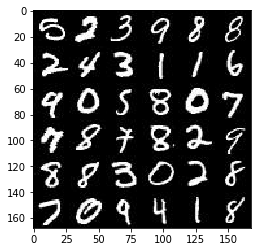

In [2]:
show_n_images = 43

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

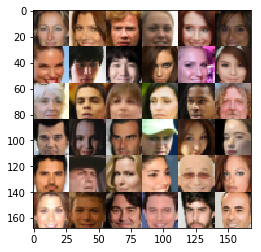

In [3]:
show_n_images = 38

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input = tf.placeholder(tf.float32,(None,image_width,image_height,image_channels),name='real_input')
    z = tf.placeholder(tf.float32,(None,z_dim),name='input_z')
    learning_rate = tf.placeholder(tf.float32,name='learning_rate')

    return real_input,z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha=0.1
    keep_prob = 0.5
    with tf.variable_scope('discriminator', reuse=reuse):
           
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
      #  dropout1=tf.layers.dropout(relu1)
        dropout1 = tf.nn.dropout(relu1, keep_prob)
        # 16x16x64
        
        x2 = tf.layers.conv2d(dropout1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
       # dropout2=tf.layers.dropout(relu2)
        dropout2 = tf.nn.dropout(relu2, keep_prob)
        # 8x8x128
        
        x3 = tf.layers.conv2d(dropout2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
      #  dropout3=tf.layers.dropout(relu3)
        dropout3 = tf.nn.dropout(relu3, keep_prob)
        # 4x4x256

        # Flattened by reshaping the tensor
        flat = tf.reshape(dropout3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
      #  dropout_logits=tf.layers.dropout(logits)
        dropout_logits = tf.nn.dropout(logits, keep_prob)
        out = tf.sigmoid(dropout_logits)
        
       

   


    return out, dropout_logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [19]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    gen_alpha=0.1
    with tf.variable_scope('generator', reuse= not is_train ):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        # Reshaped tensor to build the convolutional neural network
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        bn1 = tf.layers.batch_normalization(x1, training=is_train)
        relu1 = tf.maximum(gen_alpha * bn1, bn1)
        # 7x7x512
        
        x2 = tf.layers.conv2d_transpose(relu1, 256,5 , strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=is_train)
        relu2 = tf.maximum(gen_alpha * bn2, bn2)
        # 14x14x256 
        
        x3 = tf.layers.conv2d_transpose(relu2, 128,5 , strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=is_train)
        relu3 = tf.maximum(gen_alpha * bn3, bn3)
         # 28x28x128
        
        # Output layer
        logits = tf.layers.conv2d_transpose(relu3, out_channel_dim, 5, strides=1, padding='same') 
        #28x28x5
     
    #   # 56x56x128        
    #    logits = tf.reshape(logits,(-1,28,28,5))
    #    #28x28x5
        
        out = tf.tanh(logits)
           
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [20]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    alpha=0.1
    smooth = 0.1
    
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_logits_real) * (1 - smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_logits_real)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_logits_fake)))

    d_loss = d_loss_real + d_loss_fake

    
    
    
    return d_loss, g_loss
    

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [21]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)   
    d_update_ops = [var for var in update_ops if var.name.startswith('discriminator')]
    g_update_ops = [var for var in update_ops if var.name.startswith('generator')]

    # Optimization of Discriminator variables and Generator Variables
  #  d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
  #  g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
   # d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars) 
    with tf.control_dependencies(d_update_ops):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars) 
        
    with tf.control_dependencies(g_update_ops):   
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
       
    
    return d_train_opt, g_train_opt
    
 


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [22]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [23]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    image_width = data_shape[1]
    image_height = data_shape[2]
    output_dim = data_shape[3]


    input_real, input_z, learn_rate = model_inputs(image_width, image_height, output_dim, z_dim)

    d_loss, g_loss = model_loss(input_real, input_z, output_dim)

    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        steps = 0
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1

                #Rescaling images
                batch_images *= 2.0
               
                # Random Noise for Generator
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
             
                # Optimizing
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images,input_z: batch_z,learn_rate: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z, learn_rate: learning_rate})

                # Optimize Generator again 2nd
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z, learn_rate: learning_rate})

                # Optimize Generator again 3rd
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z, learn_rate: learning_rate})

                if steps % 10 == 0:
                    # Determine losses and print
                    d_train_loss = d_loss.eval({input_real: batch_images, input_z: batch_z})
                    g_train_loss = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{} Batch# {}...".format(epoch_i+1, epoch_count, steps),
                          "Discriminator Loss: {:.4f}...".format(d_train_loss),
                          "Generator Loss: {:.4f}".format(g_train_loss))

                if steps % 100 == 0:
                    show_generator_output(sess, 25, input_z, output_dim, data_image_mode)

    return None
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2 Batch# 10... Discriminator Loss: 2.1816... Generator Loss: 0.6940
Epoch 1/2 Batch# 20... Discriminator Loss: 1.9191... Generator Loss: 0.6293
Epoch 1/2 Batch# 30... Discriminator Loss: 2.0471... Generator Loss: 1.0034
Epoch 1/2 Batch# 40... Discriminator Loss: 2.1575... Generator Loss: 0.7850
Epoch 1/2 Batch# 50... Discriminator Loss: 1.8737... Generator Loss: 1.1107
Epoch 1/2 Batch# 60... Discriminator Loss: 2.1433... Generator Loss: 1.2157
Epoch 1/2 Batch# 70... Discriminator Loss: 1.8676... Generator Loss: 1.0735
Epoch 1/2 Batch# 80... Discriminator Loss: 2.0325... Generator Loss: 1.0959
Epoch 1/2 Batch# 90... Discriminator Loss: 2.7065... Generator Loss: 0.7161
Epoch 1/2 Batch# 100... Discriminator Loss: 1.7643... Generator Loss: 0.6584


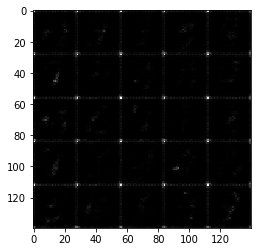

Epoch 1/2 Batch# 110... Discriminator Loss: 1.8079... Generator Loss: 1.0464
Epoch 1/2 Batch# 120... Discriminator Loss: 1.9007... Generator Loss: 1.1829
Epoch 1/2 Batch# 130... Discriminator Loss: 1.8291... Generator Loss: 1.0325
Epoch 1/2 Batch# 140... Discriminator Loss: 1.5960... Generator Loss: 1.0037
Epoch 1/2 Batch# 150... Discriminator Loss: 2.0043... Generator Loss: 1.3728
Epoch 1/2 Batch# 160... Discriminator Loss: 2.0794... Generator Loss: 1.1014
Epoch 1/2 Batch# 170... Discriminator Loss: 1.9600... Generator Loss: 1.1642
Epoch 1/2 Batch# 180... Discriminator Loss: 2.0483... Generator Loss: 1.2252
Epoch 1/2 Batch# 190... Discriminator Loss: 1.7132... Generator Loss: 0.8494
Epoch 1/2 Batch# 200... Discriminator Loss: 1.5259... Generator Loss: 1.3677


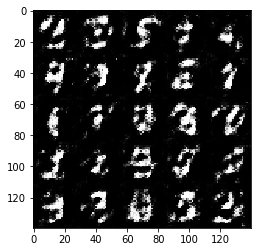

Epoch 1/2 Batch# 210... Discriminator Loss: 1.6787... Generator Loss: 1.1922
Epoch 1/2 Batch# 220... Discriminator Loss: 1.9921... Generator Loss: 0.9610
Epoch 1/2 Batch# 230... Discriminator Loss: 1.7446... Generator Loss: 0.9085
Epoch 1/2 Batch# 240... Discriminator Loss: 1.8003... Generator Loss: 0.8853
Epoch 1/2 Batch# 250... Discriminator Loss: 1.6037... Generator Loss: 0.9080
Epoch 1/2 Batch# 260... Discriminator Loss: 1.7589... Generator Loss: 0.7712
Epoch 1/2 Batch# 270... Discriminator Loss: 1.8495... Generator Loss: 0.8945
Epoch 1/2 Batch# 280... Discriminator Loss: 1.7653... Generator Loss: 0.6956
Epoch 1/2 Batch# 290... Discriminator Loss: 1.6306... Generator Loss: 0.8594
Epoch 1/2 Batch# 300... Discriminator Loss: 1.6413... Generator Loss: 1.1004


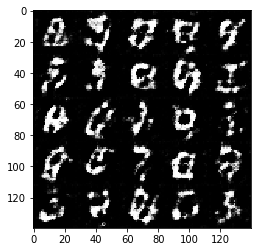

Epoch 1/2 Batch# 310... Discriminator Loss: 1.5310... Generator Loss: 1.1302
Epoch 1/2 Batch# 320... Discriminator Loss: 1.7585... Generator Loss: 0.8920
Epoch 1/2 Batch# 330... Discriminator Loss: 1.7407... Generator Loss: 0.6619
Epoch 1/2 Batch# 340... Discriminator Loss: 1.5599... Generator Loss: 0.9101
Epoch 1/2 Batch# 350... Discriminator Loss: 1.7870... Generator Loss: 1.0129
Epoch 1/2 Batch# 360... Discriminator Loss: 1.5786... Generator Loss: 1.0794
Epoch 1/2 Batch# 370... Discriminator Loss: 1.6802... Generator Loss: 0.9390
Epoch 1/2 Batch# 380... Discriminator Loss: 1.6893... Generator Loss: 0.9003
Epoch 1/2 Batch# 390... Discriminator Loss: 1.7658... Generator Loss: 1.2174
Epoch 1/2 Batch# 400... Discriminator Loss: 1.6138... Generator Loss: 0.9327


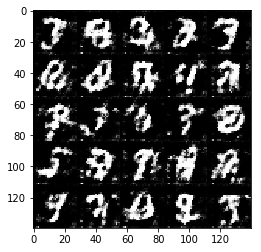

Epoch 1/2 Batch# 410... Discriminator Loss: 1.7999... Generator Loss: 0.6631
Epoch 1/2 Batch# 420... Discriminator Loss: 1.4818... Generator Loss: 0.7861
Epoch 1/2 Batch# 430... Discriminator Loss: 1.7951... Generator Loss: 0.6295
Epoch 1/2 Batch# 440... Discriminator Loss: 1.6780... Generator Loss: 0.9835
Epoch 1/2 Batch# 450... Discriminator Loss: 1.7011... Generator Loss: 0.8511
Epoch 1/2 Batch# 460... Discriminator Loss: 1.8602... Generator Loss: 0.7548
Epoch 1/2 Batch# 470... Discriminator Loss: 1.6039... Generator Loss: 0.8220
Epoch 1/2 Batch# 480... Discriminator Loss: 1.8160... Generator Loss: 0.8281
Epoch 1/2 Batch# 490... Discriminator Loss: 1.5601... Generator Loss: 0.9147
Epoch 1/2 Batch# 500... Discriminator Loss: 1.7262... Generator Loss: 0.7776


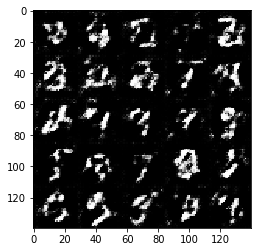

Epoch 1/2 Batch# 510... Discriminator Loss: 1.6051... Generator Loss: 0.7922
Epoch 1/2 Batch# 520... Discriminator Loss: 1.5763... Generator Loss: 0.8578
Epoch 1/2 Batch# 530... Discriminator Loss: 1.6320... Generator Loss: 0.6028
Epoch 1/2 Batch# 540... Discriminator Loss: 1.6930... Generator Loss: 0.9095
Epoch 1/2 Batch# 550... Discriminator Loss: 1.5889... Generator Loss: 1.0557
Epoch 1/2 Batch# 560... Discriminator Loss: 1.5717... Generator Loss: 1.0248
Epoch 1/2 Batch# 570... Discriminator Loss: 1.6731... Generator Loss: 0.9125
Epoch 1/2 Batch# 580... Discriminator Loss: 1.6347... Generator Loss: 0.9636
Epoch 1/2 Batch# 590... Discriminator Loss: 1.4480... Generator Loss: 0.9078
Epoch 1/2 Batch# 600... Discriminator Loss: 1.5527... Generator Loss: 0.8663


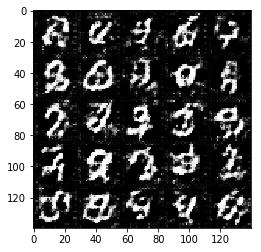

Epoch 1/2 Batch# 610... Discriminator Loss: 1.6325... Generator Loss: 0.9261
Epoch 1/2 Batch# 620... Discriminator Loss: 1.5885... Generator Loss: 0.6920
Epoch 1/2 Batch# 630... Discriminator Loss: 1.5076... Generator Loss: 0.8411
Epoch 1/2 Batch# 640... Discriminator Loss: 1.5715... Generator Loss: 1.2012
Epoch 1/2 Batch# 650... Discriminator Loss: 1.5376... Generator Loss: 0.8122
Epoch 1/2 Batch# 660... Discriminator Loss: 1.6224... Generator Loss: 0.8542
Epoch 1/2 Batch# 670... Discriminator Loss: 1.5011... Generator Loss: 0.8409
Epoch 1/2 Batch# 680... Discriminator Loss: 1.4626... Generator Loss: 0.9085
Epoch 1/2 Batch# 690... Discriminator Loss: 1.4676... Generator Loss: 0.7104
Epoch 1/2 Batch# 700... Discriminator Loss: 1.4819... Generator Loss: 0.7115


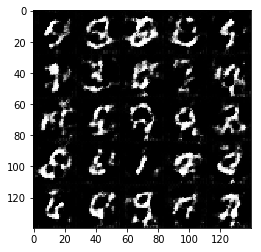

Epoch 1/2 Batch# 710... Discriminator Loss: 1.4816... Generator Loss: 0.6529
Epoch 1/2 Batch# 720... Discriminator Loss: 1.5522... Generator Loss: 0.7640
Epoch 1/2 Batch# 730... Discriminator Loss: 1.5097... Generator Loss: 0.8794
Epoch 1/2 Batch# 740... Discriminator Loss: 1.5552... Generator Loss: 0.7128
Epoch 1/2 Batch# 750... Discriminator Loss: 1.4379... Generator Loss: 0.8972
Epoch 1/2 Batch# 760... Discriminator Loss: 1.6285... Generator Loss: 0.9978
Epoch 1/2 Batch# 770... Discriminator Loss: 1.4882... Generator Loss: 0.8654
Epoch 1/2 Batch# 780... Discriminator Loss: 1.5666... Generator Loss: 0.7474
Epoch 1/2 Batch# 790... Discriminator Loss: 1.5459... Generator Loss: 0.8396
Epoch 1/2 Batch# 800... Discriminator Loss: 1.6239... Generator Loss: 0.9941


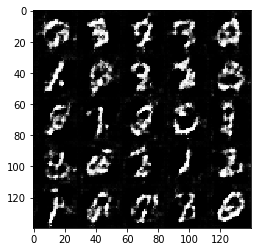

Epoch 1/2 Batch# 810... Discriminator Loss: 1.5610... Generator Loss: 0.8393
Epoch 1/2 Batch# 820... Discriminator Loss: 1.5466... Generator Loss: 0.9521
Epoch 1/2 Batch# 830... Discriminator Loss: 1.5403... Generator Loss: 0.9037
Epoch 1/2 Batch# 840... Discriminator Loss: 1.5711... Generator Loss: 0.7952
Epoch 1/2 Batch# 850... Discriminator Loss: 1.4856... Generator Loss: 0.8717
Epoch 1/2 Batch# 860... Discriminator Loss: 1.3916... Generator Loss: 0.8897
Epoch 1/2 Batch# 870... Discriminator Loss: 1.4634... Generator Loss: 0.8818
Epoch 1/2 Batch# 880... Discriminator Loss: 1.3406... Generator Loss: 0.6533
Epoch 1/2 Batch# 890... Discriminator Loss: 1.4666... Generator Loss: 0.8340
Epoch 1/2 Batch# 900... Discriminator Loss: 1.5727... Generator Loss: 0.8795


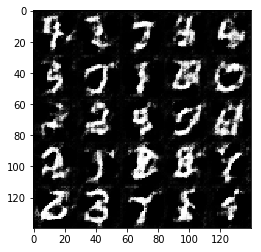

Epoch 1/2 Batch# 910... Discriminator Loss: 1.4192... Generator Loss: 0.8016
Epoch 1/2 Batch# 920... Discriminator Loss: 1.4993... Generator Loss: 0.9038
Epoch 1/2 Batch# 930... Discriminator Loss: 1.4428... Generator Loss: 0.6309
Epoch 2/2 Batch# 940... Discriminator Loss: 1.4493... Generator Loss: 0.7530
Epoch 2/2 Batch# 950... Discriminator Loss: 1.4367... Generator Loss: 0.7970
Epoch 2/2 Batch# 960... Discriminator Loss: 1.4690... Generator Loss: 0.8609
Epoch 2/2 Batch# 970... Discriminator Loss: 1.4674... Generator Loss: 0.7498
Epoch 2/2 Batch# 980... Discriminator Loss: 1.5632... Generator Loss: 0.6140
Epoch 2/2 Batch# 990... Discriminator Loss: 1.3847... Generator Loss: 0.7223
Epoch 2/2 Batch# 1000... Discriminator Loss: 1.5140... Generator Loss: 0.7268


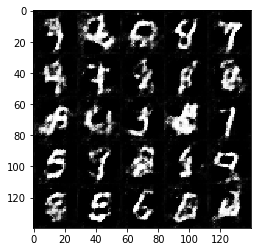

Epoch 2/2 Batch# 1010... Discriminator Loss: 1.4808... Generator Loss: 0.6408
Epoch 2/2 Batch# 1020... Discriminator Loss: 1.4715... Generator Loss: 0.9015
Epoch 2/2 Batch# 1030... Discriminator Loss: 1.5451... Generator Loss: 0.7105
Epoch 2/2 Batch# 1040... Discriminator Loss: 1.4362... Generator Loss: 0.8042
Epoch 2/2 Batch# 1050... Discriminator Loss: 1.4709... Generator Loss: 0.8441
Epoch 2/2 Batch# 1060... Discriminator Loss: 1.4808... Generator Loss: 0.6971
Epoch 2/2 Batch# 1070... Discriminator Loss: 1.5108... Generator Loss: 0.8604
Epoch 2/2 Batch# 1080... Discriminator Loss: 1.4186... Generator Loss: 0.7359
Epoch 2/2 Batch# 1090... Discriminator Loss: 1.4120... Generator Loss: 0.6725
Epoch 2/2 Batch# 1100... Discriminator Loss: 1.4540... Generator Loss: 0.7962


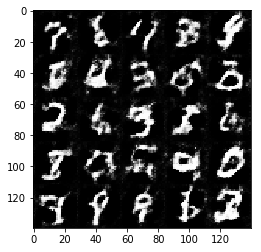

Epoch 2/2 Batch# 1110... Discriminator Loss: 1.5231... Generator Loss: 0.9701
Epoch 2/2 Batch# 1120... Discriminator Loss: 1.4502... Generator Loss: 0.8287
Epoch 2/2 Batch# 1130... Discriminator Loss: 1.4232... Generator Loss: 0.8970
Epoch 2/2 Batch# 1140... Discriminator Loss: 1.3749... Generator Loss: 0.8870
Epoch 2/2 Batch# 1150... Discriminator Loss: 1.3883... Generator Loss: 0.7990
Epoch 2/2 Batch# 1160... Discriminator Loss: 1.4711... Generator Loss: 0.9675
Epoch 2/2 Batch# 1170... Discriminator Loss: 1.4088... Generator Loss: 0.7270
Epoch 2/2 Batch# 1180... Discriminator Loss: 1.4923... Generator Loss: 0.8994
Epoch 2/2 Batch# 1190... Discriminator Loss: 1.4436... Generator Loss: 0.7498
Epoch 2/2 Batch# 1200... Discriminator Loss: 1.4377... Generator Loss: 0.7001


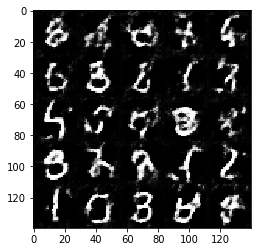

Epoch 2/2 Batch# 1210... Discriminator Loss: 1.4279... Generator Loss: 0.8541
Epoch 2/2 Batch# 1220... Discriminator Loss: 1.4925... Generator Loss: 0.9436
Epoch 2/2 Batch# 1230... Discriminator Loss: 1.3955... Generator Loss: 0.9206
Epoch 2/2 Batch# 1240... Discriminator Loss: 1.4260... Generator Loss: 0.7864
Epoch 2/2 Batch# 1250... Discriminator Loss: 1.4858... Generator Loss: 0.6731
Epoch 2/2 Batch# 1260... Discriminator Loss: 1.3871... Generator Loss: 0.8264
Epoch 2/2 Batch# 1270... Discriminator Loss: 1.3543... Generator Loss: 0.7708
Epoch 2/2 Batch# 1280... Discriminator Loss: 1.4040... Generator Loss: 0.6870
Epoch 2/2 Batch# 1290... Discriminator Loss: 1.4798... Generator Loss: 0.7812
Epoch 2/2 Batch# 1300... Discriminator Loss: 1.4943... Generator Loss: 0.7008


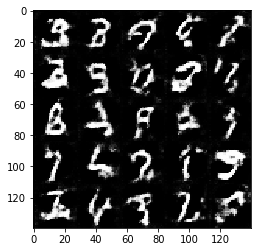

Epoch 2/2 Batch# 1310... Discriminator Loss: 1.4524... Generator Loss: 0.7198
Epoch 2/2 Batch# 1320... Discriminator Loss: 1.4563... Generator Loss: 0.8968
Epoch 2/2 Batch# 1330... Discriminator Loss: 1.4117... Generator Loss: 0.8597
Epoch 2/2 Batch# 1340... Discriminator Loss: 1.4685... Generator Loss: 0.7617
Epoch 2/2 Batch# 1350... Discriminator Loss: 1.4264... Generator Loss: 0.8336
Epoch 2/2 Batch# 1360... Discriminator Loss: 1.4166... Generator Loss: 0.7734
Epoch 2/2 Batch# 1370... Discriminator Loss: 1.4907... Generator Loss: 0.8436
Epoch 2/2 Batch# 1380... Discriminator Loss: 1.3846... Generator Loss: 0.7135
Epoch 2/2 Batch# 1390... Discriminator Loss: 1.3952... Generator Loss: 0.9418
Epoch 2/2 Batch# 1400... Discriminator Loss: 1.3719... Generator Loss: 0.8008


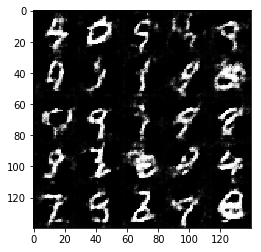

Epoch 2/2 Batch# 1410... Discriminator Loss: 1.4195... Generator Loss: 0.7731
Epoch 2/2 Batch# 1420... Discriminator Loss: 1.4238... Generator Loss: 0.7550
Epoch 2/2 Batch# 1430... Discriminator Loss: 1.4240... Generator Loss: 0.9680
Epoch 2/2 Batch# 1440... Discriminator Loss: 1.4219... Generator Loss: 0.8624
Epoch 2/2 Batch# 1450... Discriminator Loss: 1.4418... Generator Loss: 0.7499
Epoch 2/2 Batch# 1460... Discriminator Loss: 1.3129... Generator Loss: 0.8904
Epoch 2/2 Batch# 1470... Discriminator Loss: 1.4251... Generator Loss: 0.7257
Epoch 2/2 Batch# 1480... Discriminator Loss: 1.4106... Generator Loss: 0.7548
Epoch 2/2 Batch# 1490... Discriminator Loss: 1.4335... Generator Loss: 0.7554
Epoch 2/2 Batch# 1500... Discriminator Loss: 1.3982... Generator Loss: 0.6659


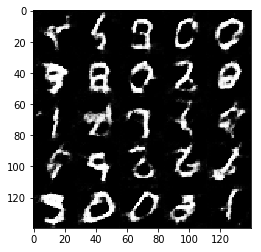

Epoch 2/2 Batch# 1510... Discriminator Loss: 1.4127... Generator Loss: 0.8209
Epoch 2/2 Batch# 1520... Discriminator Loss: 1.3794... Generator Loss: 0.7778
Epoch 2/2 Batch# 1530... Discriminator Loss: 1.4039... Generator Loss: 0.7602
Epoch 2/2 Batch# 1540... Discriminator Loss: 1.4001... Generator Loss: 0.7997
Epoch 2/2 Batch# 1550... Discriminator Loss: 1.3564... Generator Loss: 0.8036
Epoch 2/2 Batch# 1560... Discriminator Loss: 1.4644... Generator Loss: 0.7818
Epoch 2/2 Batch# 1570... Discriminator Loss: 1.4323... Generator Loss: 0.7771
Epoch 2/2 Batch# 1580... Discriminator Loss: 1.4328... Generator Loss: 0.8962
Epoch 2/2 Batch# 1590... Discriminator Loss: 1.4851... Generator Loss: 0.8070
Epoch 2/2 Batch# 1600... Discriminator Loss: 1.4587... Generator Loss: 0.8061


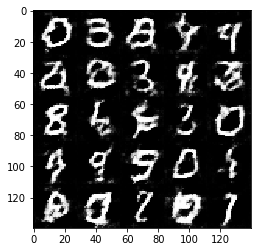

Epoch 2/2 Batch# 1610... Discriminator Loss: 1.3875... Generator Loss: 0.8519
Epoch 2/2 Batch# 1620... Discriminator Loss: 1.4380... Generator Loss: 0.7242
Epoch 2/2 Batch# 1630... Discriminator Loss: 1.4328... Generator Loss: 0.6878
Epoch 2/2 Batch# 1640... Discriminator Loss: 1.4504... Generator Loss: 0.8170
Epoch 2/2 Batch# 1650... Discriminator Loss: 1.4279... Generator Loss: 0.9105
Epoch 2/2 Batch# 1660... Discriminator Loss: 1.4712... Generator Loss: 0.8570
Epoch 2/2 Batch# 1670... Discriminator Loss: 1.4560... Generator Loss: 0.7810
Epoch 2/2 Batch# 1680... Discriminator Loss: 1.4112... Generator Loss: 0.7087
Epoch 2/2 Batch# 1690... Discriminator Loss: 1.4009... Generator Loss: 0.6985
Epoch 2/2 Batch# 1700... Discriminator Loss: 1.3950... Generator Loss: 0.8741


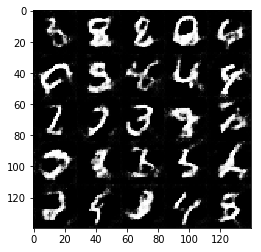

Epoch 2/2 Batch# 1710... Discriminator Loss: 1.4297... Generator Loss: 0.7430
Epoch 2/2 Batch# 1720... Discriminator Loss: 1.4148... Generator Loss: 0.8739
Epoch 2/2 Batch# 1730... Discriminator Loss: 1.5430... Generator Loss: 0.8621
Epoch 2/2 Batch# 1740... Discriminator Loss: 1.4147... Generator Loss: 0.7609
Epoch 2/2 Batch# 1750... Discriminator Loss: 1.4022... Generator Loss: 0.8440
Epoch 2/2 Batch# 1760... Discriminator Loss: 1.3657... Generator Loss: 0.7842
Epoch 2/2 Batch# 1770... Discriminator Loss: 1.4259... Generator Loss: 0.6895
Epoch 2/2 Batch# 1780... Discriminator Loss: 1.4427... Generator Loss: 0.7564
Epoch 2/2 Batch# 1790... Discriminator Loss: 1.3929... Generator Loss: 0.7641
Epoch 2/2 Batch# 1800... Discriminator Loss: 1.4095... Generator Loss: 0.7428


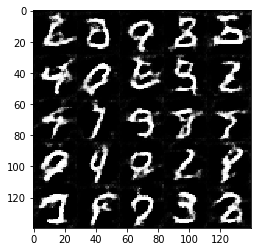

Epoch 2/2 Batch# 1810... Discriminator Loss: 1.3720... Generator Loss: 0.7239
Epoch 2/2 Batch# 1820... Discriminator Loss: 1.4198... Generator Loss: 0.7008
Epoch 2/2 Batch# 1830... Discriminator Loss: 1.3962... Generator Loss: 0.7071
Epoch 2/2 Batch# 1840... Discriminator Loss: 1.4389... Generator Loss: 0.7796
Epoch 2/2 Batch# 1850... Discriminator Loss: 1.4231... Generator Loss: 0.7272
Epoch 2/2 Batch# 1860... Discriminator Loss: 1.4190... Generator Loss: 0.8147
Epoch 2/2 Batch# 1870... Discriminator Loss: 1.3788... Generator Loss: 0.8334


In [28]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1 Batch# 10... Discriminator Loss: 1.7487... Generator Loss: 1.0651
Epoch 1/1 Batch# 20... Discriminator Loss: 2.1301... Generator Loss: 0.8701
Epoch 1/1 Batch# 30... Discriminator Loss: 1.7485... Generator Loss: 0.8908
Epoch 1/1 Batch# 40... Discriminator Loss: 1.8016... Generator Loss: 0.9827
Epoch 1/1 Batch# 50... Discriminator Loss: 1.8417... Generator Loss: 0.8544
Epoch 1/1 Batch# 60... Discriminator Loss: 2.0077... Generator Loss: 0.8491
Epoch 1/1 Batch# 70... Discriminator Loss: 2.1176... Generator Loss: 0.8777
Epoch 1/1 Batch# 80... Discriminator Loss: 2.2073... Generator Loss: 0.6792
Epoch 1/1 Batch# 90... Discriminator Loss: 1.7975... Generator Loss: 0.9242
Epoch 1/1 Batch# 100... Discriminator Loss: 1.7008... Generator Loss: 1.1424


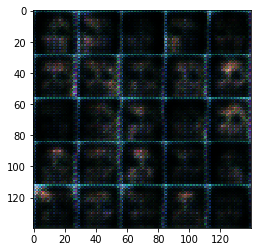

Epoch 1/1 Batch# 110... Discriminator Loss: 1.9277... Generator Loss: 0.4938
Epoch 1/1 Batch# 120... Discriminator Loss: 1.9390... Generator Loss: 0.9270
Epoch 1/1 Batch# 130... Discriminator Loss: 1.8104... Generator Loss: 1.4890
Epoch 1/1 Batch# 140... Discriminator Loss: 2.1081... Generator Loss: 0.9987
Epoch 1/1 Batch# 150... Discriminator Loss: 2.0326... Generator Loss: 1.5774
Epoch 1/1 Batch# 160... Discriminator Loss: 1.7435... Generator Loss: 0.9107
Epoch 1/1 Batch# 170... Discriminator Loss: 1.6637... Generator Loss: 0.7656
Epoch 1/1 Batch# 180... Discriminator Loss: 1.8476... Generator Loss: 1.1986
Epoch 1/1 Batch# 190... Discriminator Loss: 1.8009... Generator Loss: 1.0958
Epoch 1/1 Batch# 200... Discriminator Loss: 1.8871... Generator Loss: 0.6823


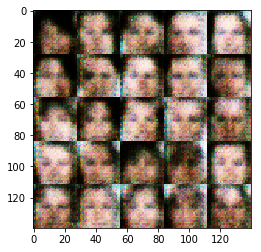

Epoch 1/1 Batch# 210... Discriminator Loss: 1.5608... Generator Loss: 0.9544
Epoch 1/1 Batch# 220... Discriminator Loss: 1.9221... Generator Loss: 0.8253
Epoch 1/1 Batch# 230... Discriminator Loss: 1.7424... Generator Loss: 0.7957
Epoch 1/1 Batch# 240... Discriminator Loss: 1.7573... Generator Loss: 0.8624
Epoch 1/1 Batch# 250... Discriminator Loss: 1.5488... Generator Loss: 1.0498
Epoch 1/1 Batch# 260... Discriminator Loss: 1.6175... Generator Loss: 1.0104
Epoch 1/1 Batch# 270... Discriminator Loss: 1.8266... Generator Loss: 0.7856
Epoch 1/1 Batch# 280... Discriminator Loss: 1.5591... Generator Loss: 0.7019
Epoch 1/1 Batch# 290... Discriminator Loss: 1.6773... Generator Loss: 0.8098
Epoch 1/1 Batch# 300... Discriminator Loss: 1.2458... Generator Loss: 1.6393


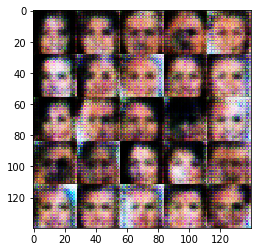

Epoch 1/1 Batch# 310... Discriminator Loss: 1.5900... Generator Loss: 1.1688
Epoch 1/1 Batch# 320... Discriminator Loss: 1.6238... Generator Loss: 1.2627
Epoch 1/1 Batch# 330... Discriminator Loss: 1.7751... Generator Loss: 0.9241
Epoch 1/1 Batch# 340... Discriminator Loss: 1.9394... Generator Loss: 0.6915
Epoch 1/1 Batch# 350... Discriminator Loss: 1.5851... Generator Loss: 0.8473
Epoch 1/1 Batch# 360... Discriminator Loss: 1.6340... Generator Loss: 0.7717
Epoch 1/1 Batch# 370... Discriminator Loss: 1.4440... Generator Loss: 1.0491
Epoch 1/1 Batch# 380... Discriminator Loss: 1.5830... Generator Loss: 0.7162
Epoch 1/1 Batch# 390... Discriminator Loss: 1.6787... Generator Loss: 1.1701
Epoch 1/1 Batch# 400... Discriminator Loss: 1.5723... Generator Loss: 0.8429


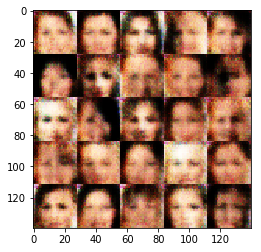

Epoch 1/1 Batch# 410... Discriminator Loss: 1.5736... Generator Loss: 0.7788
Epoch 1/1 Batch# 420... Discriminator Loss: 1.3658... Generator Loss: 0.9045
Epoch 1/1 Batch# 430... Discriminator Loss: 1.5678... Generator Loss: 0.8272
Epoch 1/1 Batch# 440... Discriminator Loss: 1.7584... Generator Loss: 0.6262
Epoch 1/1 Batch# 450... Discriminator Loss: 1.4656... Generator Loss: 0.8501
Epoch 1/1 Batch# 460... Discriminator Loss: 1.5932... Generator Loss: 0.7547
Epoch 1/1 Batch# 470... Discriminator Loss: 1.6125... Generator Loss: 0.8424
Epoch 1/1 Batch# 480... Discriminator Loss: 1.6429... Generator Loss: 0.9609
Epoch 1/1 Batch# 490... Discriminator Loss: 1.6375... Generator Loss: 0.7447
Epoch 1/1 Batch# 500... Discriminator Loss: 1.5928... Generator Loss: 0.8190


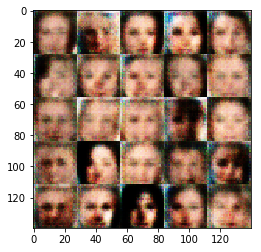

Epoch 1/1 Batch# 510... Discriminator Loss: 1.5067... Generator Loss: 0.8843
Epoch 1/1 Batch# 520... Discriminator Loss: 1.6791... Generator Loss: 0.8410
Epoch 1/1 Batch# 530... Discriminator Loss: 1.4661... Generator Loss: 0.9974
Epoch 1/1 Batch# 540... Discriminator Loss: 1.8339... Generator Loss: 0.6371
Epoch 1/1 Batch# 550... Discriminator Loss: 1.6323... Generator Loss: 1.0116
Epoch 1/1 Batch# 560... Discriminator Loss: 1.8132... Generator Loss: 0.7146
Epoch 1/1 Batch# 570... Discriminator Loss: 1.5661... Generator Loss: 0.6604
Epoch 1/1 Batch# 580... Discriminator Loss: 1.6899... Generator Loss: 1.0681
Epoch 1/1 Batch# 590... Discriminator Loss: 1.5638... Generator Loss: 0.7069
Epoch 1/1 Batch# 600... Discriminator Loss: 1.4800... Generator Loss: 0.8189


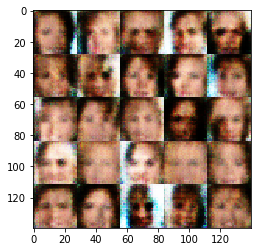

Epoch 1/1 Batch# 610... Discriminator Loss: 1.3752... Generator Loss: 0.9503
Epoch 1/1 Batch# 620... Discriminator Loss: 1.5856... Generator Loss: 0.6761
Epoch 1/1 Batch# 630... Discriminator Loss: 1.4229... Generator Loss: 0.7335
Epoch 1/1 Batch# 640... Discriminator Loss: 1.5977... Generator Loss: 0.7720
Epoch 1/1 Batch# 650... Discriminator Loss: 1.3515... Generator Loss: 1.2202
Epoch 1/1 Batch# 660... Discriminator Loss: 1.5093... Generator Loss: 0.8267
Epoch 1/1 Batch# 670... Discriminator Loss: 1.4702... Generator Loss: 0.7843
Epoch 1/1 Batch# 680... Discriminator Loss: 1.5269... Generator Loss: 1.0048
Epoch 1/1 Batch# 690... Discriminator Loss: 1.5998... Generator Loss: 0.6689
Epoch 1/1 Batch# 700... Discriminator Loss: 1.5260... Generator Loss: 0.7247


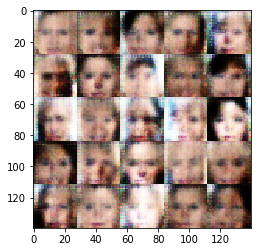

Epoch 1/1 Batch# 710... Discriminator Loss: 1.5846... Generator Loss: 0.6485
Epoch 1/1 Batch# 720... Discriminator Loss: 1.5958... Generator Loss: 0.6825
Epoch 1/1 Batch# 730... Discriminator Loss: 1.6711... Generator Loss: 0.7133
Epoch 1/1 Batch# 740... Discriminator Loss: 1.5478... Generator Loss: 0.6814
Epoch 1/1 Batch# 750... Discriminator Loss: 1.5186... Generator Loss: 0.7886
Epoch 1/1 Batch# 760... Discriminator Loss: 1.4669... Generator Loss: 0.8030
Epoch 1/1 Batch# 770... Discriminator Loss: 1.7138... Generator Loss: 0.6964
Epoch 1/1 Batch# 780... Discriminator Loss: 1.5265... Generator Loss: 0.8155
Epoch 1/1 Batch# 790... Discriminator Loss: 1.6199... Generator Loss: 0.6811
Epoch 1/1 Batch# 800... Discriminator Loss: 1.6413... Generator Loss: 0.8238


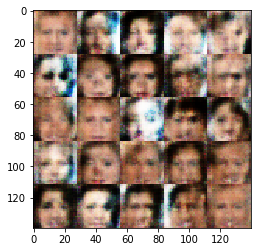

Epoch 1/1 Batch# 810... Discriminator Loss: 1.4035... Generator Loss: 0.6584
Epoch 1/1 Batch# 820... Discriminator Loss: 1.7109... Generator Loss: 0.7607
Epoch 1/1 Batch# 830... Discriminator Loss: 1.4640... Generator Loss: 0.8574
Epoch 1/1 Batch# 840... Discriminator Loss: 1.5676... Generator Loss: 0.6793
Epoch 1/1 Batch# 850... Discriminator Loss: 1.3734... Generator Loss: 0.8101
Epoch 1/1 Batch# 860... Discriminator Loss: 1.4583... Generator Loss: 0.8020
Epoch 1/1 Batch# 870... Discriminator Loss: 1.6564... Generator Loss: 0.6804
Epoch 1/1 Batch# 880... Discriminator Loss: 1.5113... Generator Loss: 0.7522
Epoch 1/1 Batch# 890... Discriminator Loss: 1.5947... Generator Loss: 0.7892
Epoch 1/1 Batch# 900... Discriminator Loss: 1.4290... Generator Loss: 0.8242


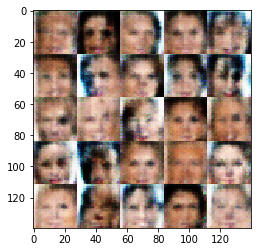

Epoch 1/1 Batch# 910... Discriminator Loss: 1.4448... Generator Loss: 0.7598
Epoch 1/1 Batch# 920... Discriminator Loss: 1.5579... Generator Loss: 0.8905
Epoch 1/1 Batch# 930... Discriminator Loss: 1.5090... Generator Loss: 0.7160
Epoch 1/1 Batch# 940... Discriminator Loss: 1.4977... Generator Loss: 0.9122
Epoch 1/1 Batch# 950... Discriminator Loss: 1.4008... Generator Loss: 0.7469
Epoch 1/1 Batch# 960... Discriminator Loss: 1.6101... Generator Loss: 0.7228
Epoch 1/1 Batch# 970... Discriminator Loss: 1.5650... Generator Loss: 0.7690
Epoch 1/1 Batch# 980... Discriminator Loss: 1.4295... Generator Loss: 0.9222
Epoch 1/1 Batch# 990... Discriminator Loss: 1.4838... Generator Loss: 0.7936
Epoch 1/1 Batch# 1000... Discriminator Loss: 1.4054... Generator Loss: 0.7970


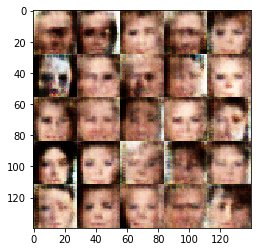

Epoch 1/1 Batch# 1010... Discriminator Loss: 1.5311... Generator Loss: 0.8411
Epoch 1/1 Batch# 1020... Discriminator Loss: 1.4244... Generator Loss: 0.8028
Epoch 1/1 Batch# 1030... Discriminator Loss: 1.5095... Generator Loss: 0.7688
Epoch 1/1 Batch# 1040... Discriminator Loss: 1.4590... Generator Loss: 0.6817
Epoch 1/1 Batch# 1050... Discriminator Loss: 1.4121... Generator Loss: 0.7383
Epoch 1/1 Batch# 1060... Discriminator Loss: 1.5369... Generator Loss: 0.6987
Epoch 1/1 Batch# 1070... Discriminator Loss: 1.4723... Generator Loss: 0.6404
Epoch 1/1 Batch# 1080... Discriminator Loss: 1.4559... Generator Loss: 0.8377
Epoch 1/1 Batch# 1090... Discriminator Loss: 1.5069... Generator Loss: 0.8655
Epoch 1/1 Batch# 1100... Discriminator Loss: 1.4692... Generator Loss: 0.7683


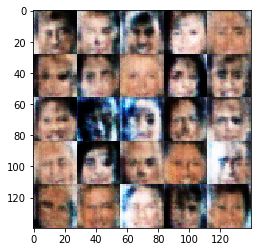

Epoch 1/1 Batch# 1110... Discriminator Loss: 1.5629... Generator Loss: 0.8985
Epoch 1/1 Batch# 1120... Discriminator Loss: 1.5509... Generator Loss: 0.7928
Epoch 1/1 Batch# 1130... Discriminator Loss: 1.4009... Generator Loss: 0.8079
Epoch 1/1 Batch# 1140... Discriminator Loss: 1.5155... Generator Loss: 0.7568
Epoch 1/1 Batch# 1150... Discriminator Loss: 1.4021... Generator Loss: 0.6951
Epoch 1/1 Batch# 1160... Discriminator Loss: 1.5071... Generator Loss: 0.7599
Epoch 1/1 Batch# 1170... Discriminator Loss: 1.5760... Generator Loss: 0.7822
Epoch 1/1 Batch# 1180... Discriminator Loss: 1.4502... Generator Loss: 0.7292
Epoch 1/1 Batch# 1190... Discriminator Loss: 1.5408... Generator Loss: 0.7686
Epoch 1/1 Batch# 1200... Discriminator Loss: 1.4644... Generator Loss: 0.8219


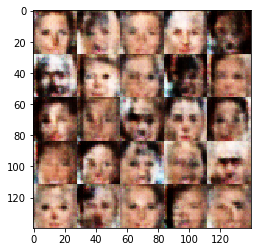

Epoch 1/1 Batch# 1210... Discriminator Loss: 1.4880... Generator Loss: 0.7021
Epoch 1/1 Batch# 1220... Discriminator Loss: 1.4908... Generator Loss: 0.7029
Epoch 1/1 Batch# 1230... Discriminator Loss: 1.4462... Generator Loss: 0.8478
Epoch 1/1 Batch# 1240... Discriminator Loss: 1.3568... Generator Loss: 0.7380
Epoch 1/1 Batch# 1250... Discriminator Loss: 1.5031... Generator Loss: 0.7801
Epoch 1/1 Batch# 1260... Discriminator Loss: 1.4219... Generator Loss: 0.6324
Epoch 1/1 Batch# 1270... Discriminator Loss: 1.4551... Generator Loss: 0.7934
Epoch 1/1 Batch# 1280... Discriminator Loss: 1.4146... Generator Loss: 0.7967
Epoch 1/1 Batch# 1290... Discriminator Loss: 1.3979... Generator Loss: 0.7766
Epoch 1/1 Batch# 1300... Discriminator Loss: 1.5176... Generator Loss: 0.7590


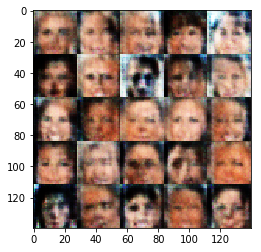

Epoch 1/1 Batch# 1310... Discriminator Loss: 1.4653... Generator Loss: 0.7083
Epoch 1/1 Batch# 1320... Discriminator Loss: 1.4559... Generator Loss: 0.7906
Epoch 1/1 Batch# 1330... Discriminator Loss: 1.4081... Generator Loss: 0.6985
Epoch 1/1 Batch# 1340... Discriminator Loss: 1.4811... Generator Loss: 0.7395
Epoch 1/1 Batch# 1350... Discriminator Loss: 1.4565... Generator Loss: 0.7031
Epoch 1/1 Batch# 1360... Discriminator Loss: 1.4531... Generator Loss: 0.7381
Epoch 1/1 Batch# 1370... Discriminator Loss: 1.4182... Generator Loss: 0.7838
Epoch 1/1 Batch# 1380... Discriminator Loss: 1.4369... Generator Loss: 0.7569
Epoch 1/1 Batch# 1390... Discriminator Loss: 1.4334... Generator Loss: 0.7704
Epoch 1/1 Batch# 1400... Discriminator Loss: 1.4137... Generator Loss: 0.8205


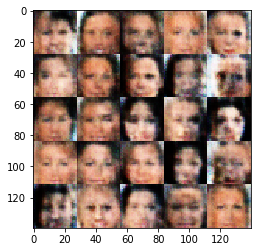

Epoch 1/1 Batch# 1410... Discriminator Loss: 1.4331... Generator Loss: 0.7368
Epoch 1/1 Batch# 1420... Discriminator Loss: 1.3863... Generator Loss: 0.8390
Epoch 1/1 Batch# 1430... Discriminator Loss: 1.3740... Generator Loss: 0.7556
Epoch 1/1 Batch# 1440... Discriminator Loss: 1.4946... Generator Loss: 0.7843
Epoch 1/1 Batch# 1450... Discriminator Loss: 1.4243... Generator Loss: 0.8197
Epoch 1/1 Batch# 1460... Discriminator Loss: 1.4473... Generator Loss: 0.6829
Epoch 1/1 Batch# 1470... Discriminator Loss: 1.4856... Generator Loss: 0.7337
Epoch 1/1 Batch# 1480... Discriminator Loss: 1.4630... Generator Loss: 0.7081
Epoch 1/1 Batch# 1490... Discriminator Loss: 1.4309... Generator Loss: 0.7136
Epoch 1/1 Batch# 1500... Discriminator Loss: 1.4962... Generator Loss: 0.7268


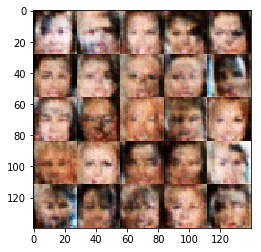

Epoch 1/1 Batch# 1510... Discriminator Loss: 1.5121... Generator Loss: 0.7127
Epoch 1/1 Batch# 1520... Discriminator Loss: 1.3990... Generator Loss: 0.7825
Epoch 1/1 Batch# 1530... Discriminator Loss: 1.4342... Generator Loss: 0.7762
Epoch 1/1 Batch# 1540... Discriminator Loss: 1.4233... Generator Loss: 0.7084
Epoch 1/1 Batch# 1550... Discriminator Loss: 1.4635... Generator Loss: 0.8083
Epoch 1/1 Batch# 1560... Discriminator Loss: 1.4985... Generator Loss: 0.7795
Epoch 1/1 Batch# 1570... Discriminator Loss: 1.5317... Generator Loss: 0.7379
Epoch 1/1 Batch# 1580... Discriminator Loss: 1.4921... Generator Loss: 0.7612
Epoch 1/1 Batch# 1590... Discriminator Loss: 1.4313... Generator Loss: 0.8818
Epoch 1/1 Batch# 1600... Discriminator Loss: 1.4510... Generator Loss: 0.8637


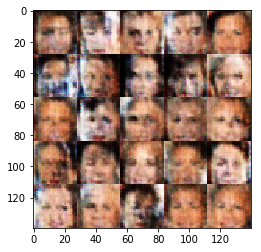

Epoch 1/1 Batch# 1610... Discriminator Loss: 1.4491... Generator Loss: 0.8033
Epoch 1/1 Batch# 1620... Discriminator Loss: 1.3909... Generator Loss: 0.6684
Epoch 1/1 Batch# 1630... Discriminator Loss: 1.5159... Generator Loss: 0.6691
Epoch 1/1 Batch# 1640... Discriminator Loss: 1.4435... Generator Loss: 0.7154
Epoch 1/1 Batch# 1650... Discriminator Loss: 1.4274... Generator Loss: 0.8219
Epoch 1/1 Batch# 1660... Discriminator Loss: 1.4606... Generator Loss: 0.6301
Epoch 1/1 Batch# 1670... Discriminator Loss: 1.4749... Generator Loss: 0.7057
Epoch 1/1 Batch# 1680... Discriminator Loss: 1.4595... Generator Loss: 0.6932
Epoch 1/1 Batch# 1690... Discriminator Loss: 1.4147... Generator Loss: 0.7699
Epoch 1/1 Batch# 1700... Discriminator Loss: 1.4599... Generator Loss: 0.7465


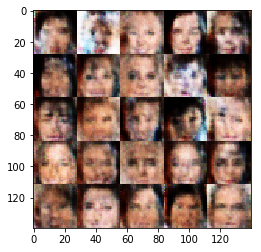

Epoch 1/1 Batch# 1710... Discriminator Loss: 1.4737... Generator Loss: 0.9236
Epoch 1/1 Batch# 1720... Discriminator Loss: 1.4117... Generator Loss: 0.7061
Epoch 1/1 Batch# 1730... Discriminator Loss: 1.4035... Generator Loss: 0.7396
Epoch 1/1 Batch# 1740... Discriminator Loss: 1.4160... Generator Loss: 0.8183
Epoch 1/1 Batch# 1750... Discriminator Loss: 1.4301... Generator Loss: 0.7904
Epoch 1/1 Batch# 1760... Discriminator Loss: 1.4745... Generator Loss: 0.7419
Epoch 1/1 Batch# 1770... Discriminator Loss: 1.4725... Generator Loss: 0.8155
Epoch 1/1 Batch# 1780... Discriminator Loss: 1.4082... Generator Loss: 0.8053
Epoch 1/1 Batch# 1790... Discriminator Loss: 1.3769... Generator Loss: 0.7752
Epoch 1/1 Batch# 1800... Discriminator Loss: 1.3856... Generator Loss: 0.7943


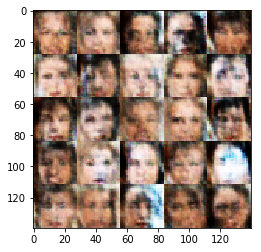

Epoch 1/1 Batch# 1810... Discriminator Loss: 1.3793... Generator Loss: 0.7361
Epoch 1/1 Batch# 1820... Discriminator Loss: 1.4686... Generator Loss: 0.7268
Epoch 1/1 Batch# 1830... Discriminator Loss: 1.4388... Generator Loss: 0.7081
Epoch 1/1 Batch# 1840... Discriminator Loss: 1.4589... Generator Loss: 0.7062
Epoch 1/1 Batch# 1850... Discriminator Loss: 1.4189... Generator Loss: 0.7711
Epoch 1/1 Batch# 1860... Discriminator Loss: 1.4408... Generator Loss: 0.7729
Epoch 1/1 Batch# 1870... Discriminator Loss: 1.4251... Generator Loss: 0.7250
Epoch 1/1 Batch# 1880... Discriminator Loss: 1.4729... Generator Loss: 0.7728
Epoch 1/1 Batch# 1890... Discriminator Loss: 1.4795... Generator Loss: 0.7363
Epoch 1/1 Batch# 1900... Discriminator Loss: 1.4694... Generator Loss: 0.7965


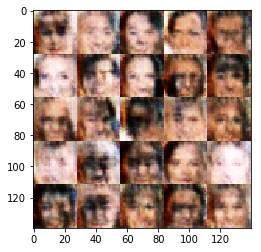

Epoch 1/1 Batch# 1910... Discriminator Loss: 1.4071... Generator Loss: 0.7663
Epoch 1/1 Batch# 1920... Discriminator Loss: 1.4526... Generator Loss: 0.8050
Epoch 1/1 Batch# 1930... Discriminator Loss: 1.4453... Generator Loss: 0.7131
Epoch 1/1 Batch# 1940... Discriminator Loss: 1.4951... Generator Loss: 0.6773
Epoch 1/1 Batch# 1950... Discriminator Loss: 1.4679... Generator Loss: 0.7319
Epoch 1/1 Batch# 1960... Discriminator Loss: 1.4437... Generator Loss: 0.7918
Epoch 1/1 Batch# 1970... Discriminator Loss: 1.4399... Generator Loss: 0.7733
Epoch 1/1 Batch# 1980... Discriminator Loss: 1.4056... Generator Loss: 0.7378
Epoch 1/1 Batch# 1990... Discriminator Loss: 1.4045... Generator Loss: 0.7143
Epoch 1/1 Batch# 2000... Discriminator Loss: 1.4223... Generator Loss: 0.7450


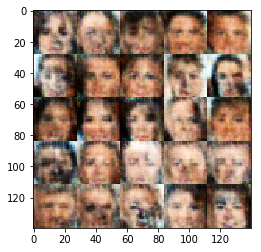

Epoch 1/1 Batch# 2010... Discriminator Loss: 1.4502... Generator Loss: 0.6858
Epoch 1/1 Batch# 2020... Discriminator Loss: 1.4029... Generator Loss: 0.7083
Epoch 1/1 Batch# 2030... Discriminator Loss: 1.4704... Generator Loss: 0.7633
Epoch 1/1 Batch# 2040... Discriminator Loss: 1.4316... Generator Loss: 0.7582
Epoch 1/1 Batch# 2050... Discriminator Loss: 1.4155... Generator Loss: 0.7344
Epoch 1/1 Batch# 2060... Discriminator Loss: 1.4298... Generator Loss: 0.7379
Epoch 1/1 Batch# 2070... Discriminator Loss: 1.3848... Generator Loss: 0.7885
Epoch 1/1 Batch# 2080... Discriminator Loss: 1.4406... Generator Loss: 0.7682
Epoch 1/1 Batch# 2090... Discriminator Loss: 1.5005... Generator Loss: 0.7854
Epoch 1/1 Batch# 2100... Discriminator Loss: 1.4227... Generator Loss: 0.7924


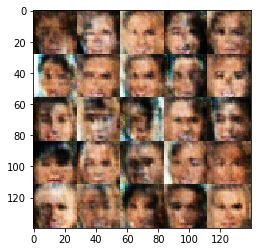

Epoch 1/1 Batch# 2110... Discriminator Loss: 1.4695... Generator Loss: 0.7942
Epoch 1/1 Batch# 2120... Discriminator Loss: 1.4346... Generator Loss: 0.7837
Epoch 1/1 Batch# 2130... Discriminator Loss: 1.4604... Generator Loss: 0.7754
Epoch 1/1 Batch# 2140... Discriminator Loss: 1.4268... Generator Loss: 0.7895
Epoch 1/1 Batch# 2150... Discriminator Loss: 1.3868... Generator Loss: 0.6960
Epoch 1/1 Batch# 2160... Discriminator Loss: 1.4037... Generator Loss: 0.7348
Epoch 1/1 Batch# 2170... Discriminator Loss: 1.4377... Generator Loss: 0.7134
Epoch 1/1 Batch# 2180... Discriminator Loss: 1.4713... Generator Loss: 0.7137
Epoch 1/1 Batch# 2190... Discriminator Loss: 1.4215... Generator Loss: 0.7444
Epoch 1/1 Batch# 2200... Discriminator Loss: 1.4115... Generator Loss: 0.7854


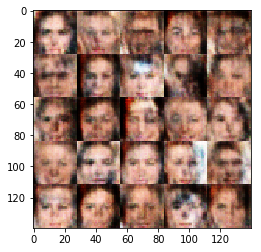

Epoch 1/1 Batch# 2210... Discriminator Loss: 1.3905... Generator Loss: 0.6788
Epoch 1/1 Batch# 2220... Discriminator Loss: 1.4060... Generator Loss: 0.6929
Epoch 1/1 Batch# 2230... Discriminator Loss: 1.3832... Generator Loss: 0.7437
Epoch 1/1 Batch# 2240... Discriminator Loss: 1.3742... Generator Loss: 0.7484
Epoch 1/1 Batch# 2250... Discriminator Loss: 1.4120... Generator Loss: 0.7647
Epoch 1/1 Batch# 2260... Discriminator Loss: 1.4284... Generator Loss: 0.7355
Epoch 1/1 Batch# 2270... Discriminator Loss: 1.3840... Generator Loss: 0.7581
Epoch 1/1 Batch# 2280... Discriminator Loss: 1.4478... Generator Loss: 0.7269
Epoch 1/1 Batch# 2290... Discriminator Loss: 1.4245... Generator Loss: 0.6895
Epoch 1/1 Batch# 2300... Discriminator Loss: 1.4437... Generator Loss: 0.7260


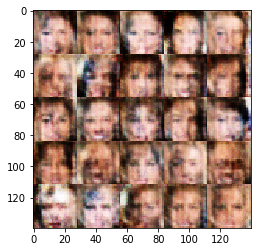

Epoch 1/1 Batch# 2310... Discriminator Loss: 1.4375... Generator Loss: 0.7921
Epoch 1/1 Batch# 2320... Discriminator Loss: 1.4037... Generator Loss: 0.7199
Epoch 1/1 Batch# 2330... Discriminator Loss: 1.4423... Generator Loss: 0.7588
Epoch 1/1 Batch# 2340... Discriminator Loss: 1.4113... Generator Loss: 0.7540
Epoch 1/1 Batch# 2350... Discriminator Loss: 1.4381... Generator Loss: 0.7133
Epoch 1/1 Batch# 2360... Discriminator Loss: 1.4574... Generator Loss: 0.7495
Epoch 1/1 Batch# 2370... Discriminator Loss: 1.3934... Generator Loss: 0.7836
Epoch 1/1 Batch# 2380... Discriminator Loss: 1.4457... Generator Loss: 0.7455
Epoch 1/1 Batch# 2390... Discriminator Loss: 1.4361... Generator Loss: 0.7940
Epoch 1/1 Batch# 2400... Discriminator Loss: 1.3425... Generator Loss: 0.7568


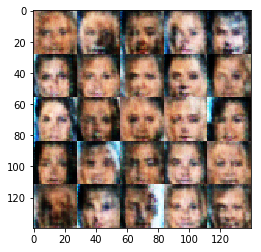

Epoch 1/1 Batch# 2410... Discriminator Loss: 1.4145... Generator Loss: 0.7754
Epoch 1/1 Batch# 2420... Discriminator Loss: 1.4012... Generator Loss: 0.7925
Epoch 1/1 Batch# 2430... Discriminator Loss: 1.4443... Generator Loss: 0.7818
Epoch 1/1 Batch# 2440... Discriminator Loss: 1.4095... Generator Loss: 0.7097
Epoch 1/1 Batch# 2450... Discriminator Loss: 1.4641... Generator Loss: 0.7901
Epoch 1/1 Batch# 2460... Discriminator Loss: 1.4206... Generator Loss: 0.7540
Epoch 1/1 Batch# 2470... Discriminator Loss: 1.3745... Generator Loss: 0.7650
Epoch 1/1 Batch# 2480... Discriminator Loss: 1.3701... Generator Loss: 0.7547
Epoch 1/1 Batch# 2490... Discriminator Loss: 1.4231... Generator Loss: 0.7067
Epoch 1/1 Batch# 2500... Discriminator Loss: 1.4019... Generator Loss: 0.7935


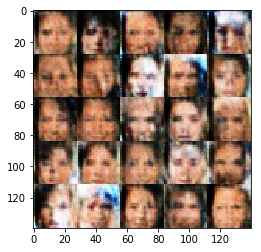

Epoch 1/1 Batch# 2510... Discriminator Loss: 1.4271... Generator Loss: 0.8197
Epoch 1/1 Batch# 2520... Discriminator Loss: 1.4330... Generator Loss: 0.7193
Epoch 1/1 Batch# 2530... Discriminator Loss: 1.4617... Generator Loss: 0.7553
Epoch 1/1 Batch# 2540... Discriminator Loss: 1.4001... Generator Loss: 0.7625
Epoch 1/1 Batch# 2550... Discriminator Loss: 1.4509... Generator Loss: 0.8115
Epoch 1/1 Batch# 2560... Discriminator Loss: 1.4354... Generator Loss: 0.7383
Epoch 1/1 Batch# 2570... Discriminator Loss: 1.4351... Generator Loss: 0.7375
Epoch 1/1 Batch# 2580... Discriminator Loss: 1.4469... Generator Loss: 0.7149
Epoch 1/1 Batch# 2590... Discriminator Loss: 1.3801... Generator Loss: 0.7740
Epoch 1/1 Batch# 2600... Discriminator Loss: 1.3914... Generator Loss: 0.7625


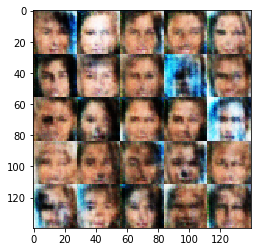

Epoch 1/1 Batch# 2610... Discriminator Loss: 1.4248... Generator Loss: 0.7044
Epoch 1/1 Batch# 2620... Discriminator Loss: 1.3641... Generator Loss: 0.7831
Epoch 1/1 Batch# 2630... Discriminator Loss: 1.3527... Generator Loss: 0.7059
Epoch 1/1 Batch# 2640... Discriminator Loss: 1.4506... Generator Loss: 0.6922
Epoch 1/1 Batch# 2650... Discriminator Loss: 1.4477... Generator Loss: 0.6759
Epoch 1/1 Batch# 2660... Discriminator Loss: 1.3814... Generator Loss: 0.7691
Epoch 1/1 Batch# 2670... Discriminator Loss: 1.3873... Generator Loss: 0.7404
Epoch 1/1 Batch# 2680... Discriminator Loss: 1.4366... Generator Loss: 0.7968
Epoch 1/1 Batch# 2690... Discriminator Loss: 1.4478... Generator Loss: 0.7152
Epoch 1/1 Batch# 2700... Discriminator Loss: 1.4844... Generator Loss: 0.7770


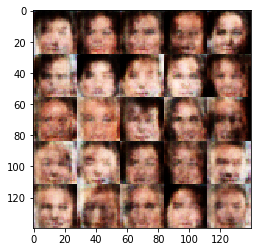

Epoch 1/1 Batch# 2710... Discriminator Loss: 1.3970... Generator Loss: 0.7789
Epoch 1/1 Batch# 2720... Discriminator Loss: 1.3847... Generator Loss: 0.7278
Epoch 1/1 Batch# 2730... Discriminator Loss: 1.3947... Generator Loss: 0.7390
Epoch 1/1 Batch# 2740... Discriminator Loss: 1.4168... Generator Loss: 0.7266
Epoch 1/1 Batch# 2750... Discriminator Loss: 1.4344... Generator Loss: 0.7006
Epoch 1/1 Batch# 2760... Discriminator Loss: 1.4005... Generator Loss: 0.7718
Epoch 1/1 Batch# 2770... Discriminator Loss: 1.4668... Generator Loss: 0.7829
Epoch 1/1 Batch# 2780... Discriminator Loss: 1.4142... Generator Loss: 0.7437
Epoch 1/1 Batch# 2790... Discriminator Loss: 1.4118... Generator Loss: 0.7626
Epoch 1/1 Batch# 2800... Discriminator Loss: 1.4232... Generator Loss: 0.6806


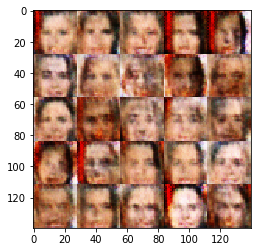

Epoch 1/1 Batch# 2810... Discriminator Loss: 1.3886... Generator Loss: 0.7008
Epoch 1/1 Batch# 2820... Discriminator Loss: 1.4274... Generator Loss: 0.7582
Epoch 1/1 Batch# 2830... Discriminator Loss: 1.4123... Generator Loss: 0.7351
Epoch 1/1 Batch# 2840... Discriminator Loss: 1.3517... Generator Loss: 0.7533
Epoch 1/1 Batch# 2850... Discriminator Loss: 1.3644... Generator Loss: 0.7736
Epoch 1/1 Batch# 2860... Discriminator Loss: 1.3854... Generator Loss: 0.7344
Epoch 1/1 Batch# 2870... Discriminator Loss: 1.4449... Generator Loss: 0.6988
Epoch 1/1 Batch# 2880... Discriminator Loss: 1.4150... Generator Loss: 0.7985
Epoch 1/1 Batch# 2890... Discriminator Loss: 1.4220... Generator Loss: 0.7704
Epoch 1/1 Batch# 2900... Discriminator Loss: 1.4295... Generator Loss: 0.7808


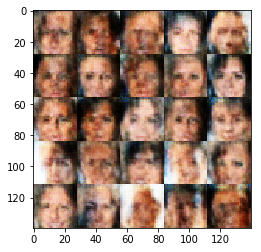

Epoch 1/1 Batch# 2910... Discriminator Loss: 1.4263... Generator Loss: 0.7747
Epoch 1/1 Batch# 2920... Discriminator Loss: 1.4435... Generator Loss: 0.7434
Epoch 1/1 Batch# 2930... Discriminator Loss: 1.4167... Generator Loss: 0.7442
Epoch 1/1 Batch# 2940... Discriminator Loss: 1.4112... Generator Loss: 0.7623
Epoch 1/1 Batch# 2950... Discriminator Loss: 1.3752... Generator Loss: 0.7574
Epoch 1/1 Batch# 2960... Discriminator Loss: 1.4096... Generator Loss: 0.7460
Epoch 1/1 Batch# 2970... Discriminator Loss: 1.4184... Generator Loss: 0.7863
Epoch 1/1 Batch# 2980... Discriminator Loss: 1.3909... Generator Loss: 0.7655
Epoch 1/1 Batch# 2990... Discriminator Loss: 1.3823... Generator Loss: 0.7180
Epoch 1/1 Batch# 3000... Discriminator Loss: 1.4047... Generator Loss: 0.6979


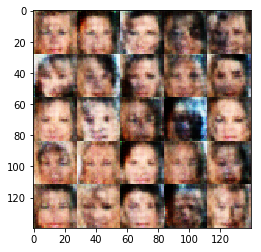

Epoch 1/1 Batch# 3010... Discriminator Loss: 1.4006... Generator Loss: 0.7581
Epoch 1/1 Batch# 3020... Discriminator Loss: 1.4154... Generator Loss: 0.7097
Epoch 1/1 Batch# 3030... Discriminator Loss: 1.4177... Generator Loss: 0.6940
Epoch 1/1 Batch# 3040... Discriminator Loss: 1.4560... Generator Loss: 0.8139
Epoch 1/1 Batch# 3050... Discriminator Loss: 1.3726... Generator Loss: 0.7760
Epoch 1/1 Batch# 3060... Discriminator Loss: 1.4276... Generator Loss: 0.7380
Epoch 1/1 Batch# 3070... Discriminator Loss: 1.4267... Generator Loss: 0.7263
Epoch 1/1 Batch# 3080... Discriminator Loss: 1.3722... Generator Loss: 0.7481
Epoch 1/1 Batch# 3090... Discriminator Loss: 1.4030... Generator Loss: 0.7518
Epoch 1/1 Batch# 3100... Discriminator Loss: 1.4033... Generator Loss: 0.7783


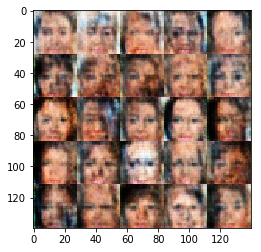

Epoch 1/1 Batch# 3110... Discriminator Loss: 1.4232... Generator Loss: 0.6750
Epoch 1/1 Batch# 3120... Discriminator Loss: 1.3970... Generator Loss: 0.7197
Epoch 1/1 Batch# 3130... Discriminator Loss: 1.4233... Generator Loss: 0.7183
Epoch 1/1 Batch# 3140... Discriminator Loss: 1.4028... Generator Loss: 0.8119
Epoch 1/1 Batch# 3150... Discriminator Loss: 1.4182... Generator Loss: 0.7470
Epoch 1/1 Batch# 3160... Discriminator Loss: 1.3901... Generator Loss: 0.7101


In [30]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.